In [1]:
import sys
import rootpath
sys.path.append(rootpath.detect())

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import wfg
from testsuite.utilities import Pareto_split
from experiments.igd_refpoints.igd_utilities import *
from scipy.spatial import distance_matrix
from tqdm import tqdm

In [2]:
from scipy.spatial import KDTree
import time

In [3]:
import time
from sklearn.neighbors import KernelDensity

In [4]:
def ds(x, n_final, kernel="gaussian"):
    kde = KernelDensity(kernel=kernel, bandwidth=0.05).fit(x)
    p = kde.score_samples(x)
    probs = (1/np.exp(p))/np.sum(1/np.exp(p))
    return x[np.random.choice(range(len(x)), n_final, replace=False, p=probs)]

In [5]:
try:
    with open('data/wfg2_2d_refpoints', 'rb') as infile:
        yf_2 = np.load(infile)
    yf_2_loaded = True
    print("2D data: loaded")
except FileNotFoundError:
    yf_2_loaded = False
    print("2D data: not found")

2D data: loaded


In [6]:
yf_2_loaded = False

In [7]:
if not yf_2_loaded:
    func = wfg.WFG2
    n_obj = 2
    l = 3
    k = 3
    n_dim = k+l
    
    M = n_obj
    N = 5000000
#     N = 50000
    y = np.zeros((N, n_obj))
    x = np.zeros((N, n_dim))
    for n in tqdm(range(N)):
        z = wfg.random_soln(k, l, func.__name__)
        y[n,:] = func(z, k, M)
        x[n,:] = z

100%|██████████| 5000000/5000000 [00:24<00:00, 201956.19it/s]


In [8]:
inds = np.argsort(y[:, 0])

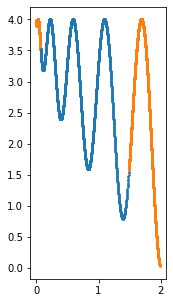

In [9]:
fig = plt.figure(figsize=[5, 5])
ax = fig.gca()
ax.scatter(*y[inds[:100000]].T, s=2, c="C1")
ax.scatter(*y[inds[100000:4900000]][::1000].T, s=2)
ax.scatter(*y[inds[4900000:]].T, s=2, c="C1")
ax.set_aspect('equal')

In [10]:
q1 = ds(y[inds[:100000]], 500)
q2 = y[inds[100000:4900000]][::1000]
q3 = ds(y[inds[4900000:]], 2000)

In [12]:
qt = np.vstack((q1, q2, q3))
qt.shape

(7300, 2)

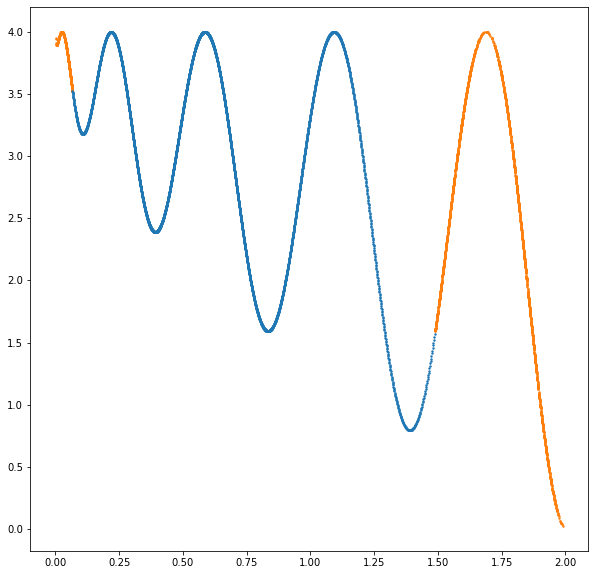

In [13]:
fig = plt.figure(figsize=[10,10])
ax = fig.gca()
ax.scatter(*q1.T, s=2, c="C1")
ax.scatter(*q2.T, s=2, c="C0")
ax.scatter(*q3.T, s= 2, c="C1")

In [14]:
qf = ds(qt, 5000, 'tophat')

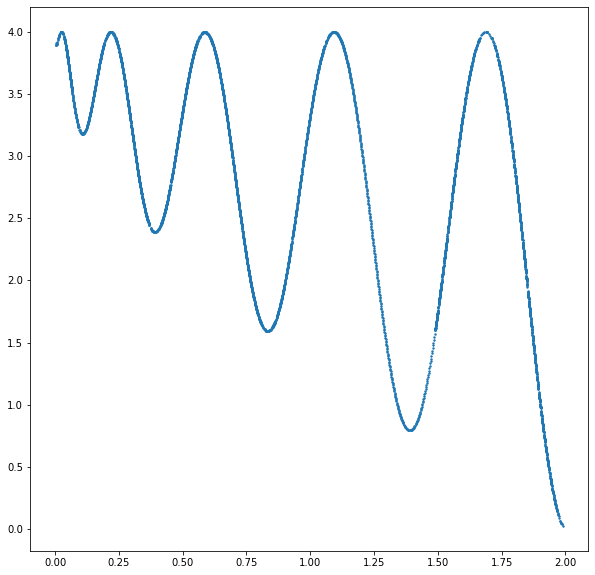

In [15]:
fig = plt.figure(figsize=[10,10])
ax = fig.gca()
ax.scatter(*qf.T, s=2, c="C0")

In [16]:
pi_qf, di_qf = Pareto_split(qf, return_indices=True)

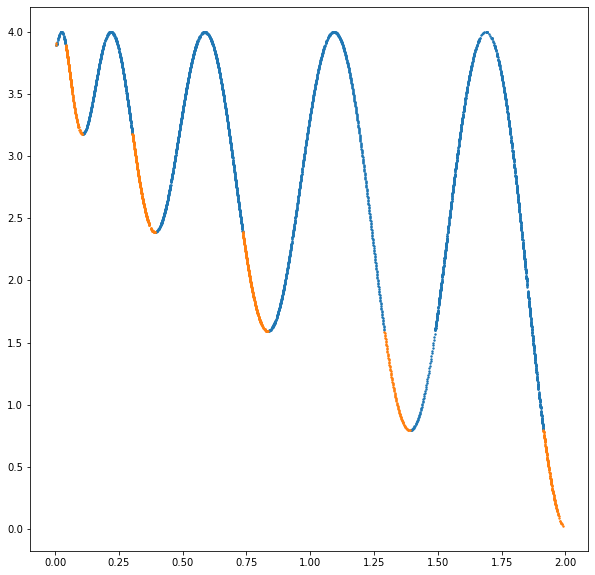

In [18]:
fig = plt.figure(figsize=[10,10])
ax = fig.gca()
ax.scatter(*qf[di_qf].T, s=2, c="C0")
ax.scatter(*qf[pi_qf].T, s=2, c="C1")

In [19]:
y_at = attainment_sample(qf[pi_qf], 2000)

100%|██████████| 2000/2000 [00:01<00:00, 1563.74it/s]


In [20]:
%%time
tree0 = KDTree(qf[pi_qf])
nn0 = tree0.query(y_at)[0]

CPU times: user 366 ms, sys: 0 ns, total: 366 ms
Wall time: 370 ms


In [21]:
%%time
tree1 = KDTree(y_at)
nn1 = tree1.query(qf[pi_qf])[0]

CPU times: user 268 ms, sys: 0 ns, total: 268 ms
Wall time: 267 ms


In [22]:
thresh_plot_0 = np.zeros(200)
thresh_plot_1 = np.zeros(200)
for i, j in tqdm(enumerate(np.linspace(0.01, 0.5, 200))):
    thresh_plot_0[i] = sum(nn0<j)
    thresh_plot_1[i] = sum(nn1<j)

200it [00:01, 118.69it/s]


In [26]:
a, b, c, d = 2, 4, 6, 8

No handles with labels found to put in legend.


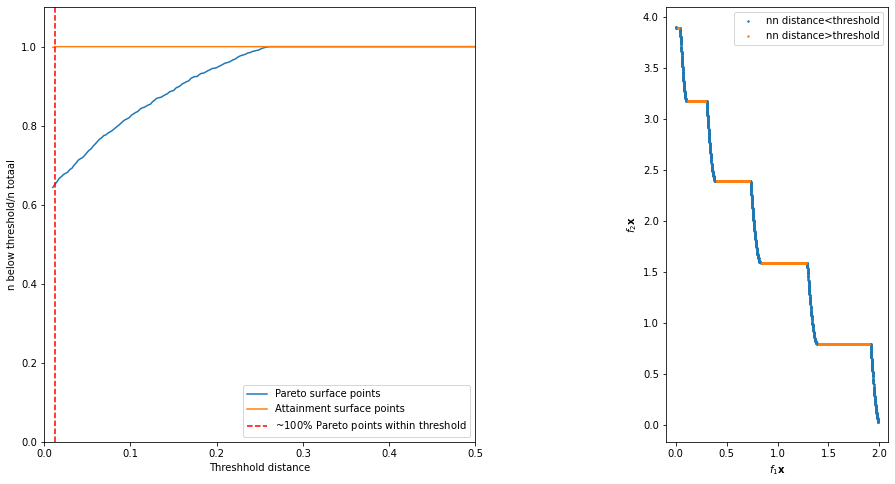

In [44]:
thresh = 0.012
      
fig = plt.figure(figsize=[17, 8])
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

yf_2 = y_at[nn0<thresh]

ax0.plot(np.linspace(0.01, 0.5, 200), np.array(thresh_plot_0)/len(nn0), label="Pareto surface points")
ax0.plot(np.linspace(0.01, 0.5, 200), np.array(thresh_plot_1)/len(nn1), label="Attainment surface points")
ax0.axvline(thresh, linestyle="--", c="r", label=r"~$100\%$ Pareto points within threshold")
ax0.set_xlabel("Threshhold distance")
ax0.set_ylabel("n below threshold/n totaal")
ax0.set_xlim([0, 0.5])
ax0.set_ylim([0, 1.1])
ax0.legend()

ax_format(ax1, axes=[2., 4., 6.], vp=[35, 15])
ax1.scatter(*yf_2.T, s=2, c="C0", label="nn distance<threshold")
ax1.scatter(*y_at[nn0>thresh, :3].T, s=2, c="C1", label="nn distance>threshold")
ax1.legend()

In [45]:
yf_2.shape

(1301, 2)

In [46]:
if yf_2_loaded is not True:
    with open('data/wfg2_2d_refpoints', 'wb') as outfile:
        np.save(outfile, yf_2)
    print("Data saved")

Data saved


Text(0.5, 0.98, 'KDE estimate of probability distribution')

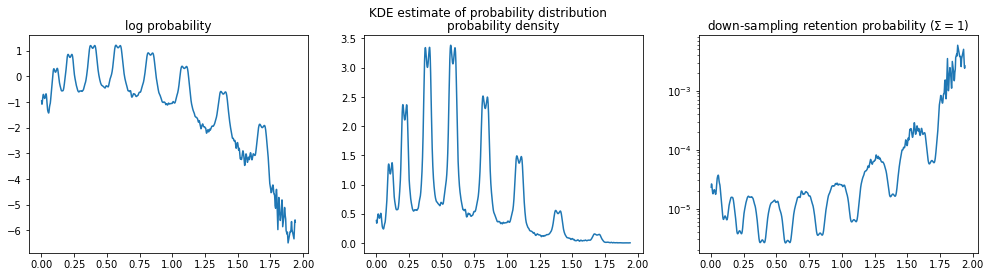

In [38]:
probs = (1/np.exp(p))/np.sum(1/np.exp(p))
fig  = plt.figure(figsize=[17, 4])
ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)

ax0.plot(y[inds, 0], p[inds])
ax1.plot(y[inds, 0], np.exp(p)[inds])
ax2.plot(y[inds, 0], probs[inds])


ax2.set_yscale('log')

ax0.set_title("log probability")
ax1.set_title("probability density")
ax2.set_title("down-sampling retention probability ($\Sigma=1$)")
fig.suptitle("KDE estimate of probability distribution")

In [47]:
y2_ind = np.random.choice(range(len(y)), 1000, replace=False, p=probs)

Text(0.5, 1.0, 'Result of downsample')

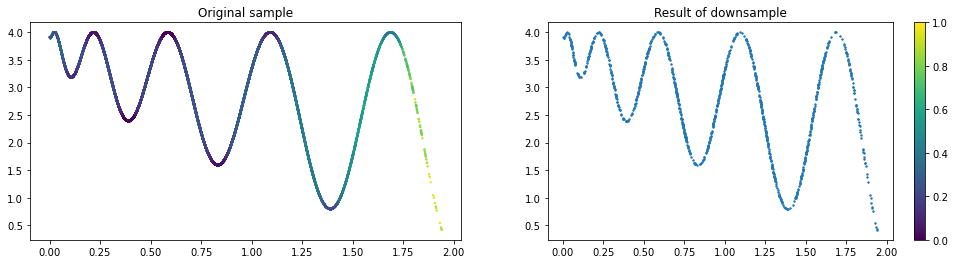

In [49]:
fig  = plt.figure(figsize=[17, 4])
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
sc = ax0.scatter(*y.T, s=2, c=np.log(probs))
sc = ax1.scatter(*y[y2_ind].T, s=2, c="C0")
fig.colorbar(sc)

ax0.set_title("Original sample")
ax1.set_title("Result of downsample")

In [51]:
try:
    with open('data/wfg2_3d_refpoints', 'rb') as infile:
        yf_3 = np.load(infile)
    yf_3_loaded = True
    print("3D data: loaded")
except FileNotFoundError:
    yf_3_loaded = False
    print("3D data: not found")

3D data: loaded


In [52]:
yf_3_loaded = False

In [77]:
if not yf_3_loaded:
    func = wfg.WFG2
    n_obj = 3
    l = 3
    k = 3
    n_dim = k+l
    
    M = n_obj
#     N = 500000
    N = 5000000
    y = np.zeros((N, n_obj))
    x = np.zeros((N, n_dim))
    for n in tqdm(range(N)):
        z = wfg.random_soln(k, l, func.__name__)
        y[n,:] = func(z, k, M)
        x[n,:] = z

100%|██████████| 500000/500000 [00:02<00:00, 201453.96it/s]


In [78]:
pi, di = Pareto_split(y, return_indices=True)

In [155]:
inds_t0 = (y[pi][:, 2]<2.389)
inds_t1 = (y[pi][:, 2]>2.389)

In [75]:
%matplotlib qt

In [81]:
fig = plt.figure(figsize=[5, 5])
ax = fig.gca(projection="3d")
ax.scatter(*y[pi].T, s=2, c="C1")
# ax.scatter(*y[inds[:100000]].T, s=2, c="C1")
# ax.scatter(*y[inds[100000:4900000]][::1000].T, s=2)
# ax.scatter(*y[inds[4900000:]].T, s=2, c="C1")
# ax.set_aspect('equal')

In [83]:
inds.shape

(137174,)

In [85]:
sum(pi)

137174

In [159]:
fig = plt.figure(figsize=[5, 5])
ax = fig.gca(projection="3d")
ax.scatter(*y[pi][inds_t0][::10].T, s=2, c="C0")
ax.scatter(*y[pi][inds_t1][::10].T, s=2, c="C1")
# ax.scatter(*y[inds[:100000]].T, s=2, c="C1")
# ax.scatter(*y[inds[100000:4900000]][::1000].T, s=2)
# ax.scatter(*y[inds[4900000:]].T, s=2, c="C1")
# ax.set_aspect('equal')

In [158]:
print(sum(inds_t0))
print(sum(inds_t1))

30781
106393


In [170]:
len(inds_t0)

137174

In [171]:
y.shape

(500000, 3)

In [177]:
aaaa = np.vstack((y[pi][inds_t0],y[pi][inds_t1][::10]))
len(aaaa)

41421

In [181]:
y_at = attainment_sample(y[pi], 10000)

100%|██████████| 10000/10000 [16:48<00:00,  9.91it/s]


In [182]:
fig = plt.figure(figsize=[5, 5])
ax = fig.gca(projection="3d")
ax.scatter(*y_at.T, s=2, c="C0")

In [183]:
%%time
tree0 = KDTree(y[pi])
nn0 = tree0.query(y_at)[0]

CPU times: user 10.1 s, sys: 31.8 ms, total: 10.1 s
Wall time: 10.1 s


In [184]:
%%time
tree1 = KDTree(y_at)
nn1 = tree1.query(y[pi])[0]

CPU times: user 27.4 s, sys: 15.9 ms, total: 27.5 s
Wall time: 27.5 s


In [185]:
thresh_plot_0 = np.zeros(200)
thresh_plot_1 = np.zeros(200)
for i, j in tqdm(enumerate(np.linspace(0.01, 0.5, 200))):
    thresh_plot_0[i] = sum(nn0<j)
    thresh_plot_1[i] = sum(nn1<j)

200it [01:29,  2.23it/s]


In [197]:
thresh = 0.04
      
fig = plt.figure(figsize=[17, 8])
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122, projection="3d")

yf_3 = y_at[nn0<thresh]

ax0.plot(np.linspace(0.01, 0.5, 200), np.array(thresh_plot_0)/len(nn0), label="Pareto surface points")
ax0.plot(np.linspace(0.01, 0.5, 200), np.array(thresh_plot_1)/len(nn1), label="Attainment surface points")
ax0.axvline(thresh, linestyle="--", c="r", label=r"~$100\%$ Pareto points within threshold")
ax0.set_xlabel("Threshhold distance")
ax0.set_ylabel("n below threshold/n totaal")
ax0.set_xlim([0, 0.5])
ax0.set_ylim([0, 1.1])
ax0.legend()

ax_format(ax1, axes=[2., 4., 6.], vp=[35, 15])
ax1.scatter(*yf_3.T, s=2, c="C0", label="nn distance<threshold")
ax1.scatter(*y_at[nn0>thresh, :3].T, s=2, c="C1", label="nn distance>threshold")
ax1.legend()

No handles with labels found to put in legend.


[2.0, 4.0, 6.0]
3d


In [198]:
fig = plt.figure(figsize=[8, 8])
ax = fig.gca(projection="3d")
ax_format(ax, axes=[2, 4, 6], vp=[35, 10])
ax.scatter(*yf_3.T, s=2, c="C0", label="Evenly distributed samples close to Pareto front")
ax.legend()

No handles with labels found to put in legend.


[2, 4, 6]
3d


In [199]:
yf_3_loaded

False

In [200]:
if not yf_3_loaded: 
    with open('data/wfg2_3d_refpoints', 'wb') as outfile:
        np.save(outfile, yf_3)
    print("Saved")

Saved


In [5]:
try:
    with open('data/wfg2_4d_refpoints', 'rb') as infile:
        yf_4 = np.load(infile)
    yf_4_loaded = True
    print("4D data: loaded")
except FileNotFoundError:
    yf_4_loaded = False
    print("4D data: not found")
yf_4.shape

4D data: loaded


(2059, 4)

In [9]:
yf_4_loaded = True 

In [12]:
func = wfg.WFG2
n_obj = 4
l = 3
k = 3
n_dim = k+l

M = n_obj
N = 5000000
y = np.zeros((N, n_obj))
x = np.zeros((N, n_dim))
for n in range(N):
    z = wfg.random_soln(k, l, func.__name__)
    y[n,:] = func(z, k, M)
    x[n,:] = z

In [ ]:
pi, di = Pareto_split(y, return_indices=True)

In [ ]:
print("Done")

In [ ]:
y_at = attainment_sample(y[pi], 10000)

In [19]:
%matplotlib qt

In [15]:
a, b, c, d = np.round(yf_4.max(axis=0))
[a, b, c, d]

[2.0, 3.0, 6.0, 8.0]

In [30]:
plt.scatter(*yf_4[:, :2].T)

In [23]:
fig = plt.figure()
ax0 = fig.add_subplot(231, projection="3d")
ax1 = fig.add_subplot(232, projection="3d")
ax2 = fig.add_subplot(233, projection="3d")
ax3 = fig.add_subplot(234, projection="3d")
ax4 = fig.add_subplot(235, projection="3d")
ax5 = fig.add_subplot(236, projection="3d")
ax_format(ax0, [a, b, c], vp=[35, 15])
ax_format(ax1, [b, c, d], vp=[35, 15])
ax_format(ax2, [a, c, d], vp=[35, 15])
ax_format(ax3, [a, b, c], vp=[35, 15])
ax_format(ax4, [b, c, d], vp=[35, 15])
ax_format(ax5, [a, c, d], vp=[35, 15])
# ax0.scatter(*y[pi][:, [0,1,2]].T, s=2)
# ax1.scatter(*y[pi][:, [1,2,3]].T, s=2)
# ax2.scatter(*y[pi][:, [0,2,3]].T, s=2)
ax3.scatter(*yf_4[:, [0,1,2]].T, s=2)
ax4.scatter(*yf_4[:, [1,2,3]].T, s=2)
ax5.scatter(*yf_4[:, [0,2,3]].T, s=2)
# y[pi].shape

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[2.0, 3.0, 6.0]
3d
[3.0, 6.0, 8.0]
3d
[2.0, 6.0, 8.0]
3d
[2.0, 3.0, 6.0]
3d
[3.0, 6.0, 8.0]
3d
[2.0, 6.0, 8.0]
3d


In [22]:
%matplotlib qt 

In [ ]:
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.scatter(*yf_4[:, [1,2,3]].T, s=2)
y[pi].shape

In [ ]:
a, b, c, d = np.round(y.max(axis=0))
fig = plt.figure(figsize=[16, 8])
ax0 = fig.add_subplot(2,3,1, projection="3d")
ax1 = fig.add_subplot(2,3,2, projection="3d")
ax2 = fig.add_subplot(2,3,3, projection="3d")
# ax3 = fig.add_subplot(2,3,4, projection="3d")
# ax4 = fig.add_subplot(2,3,5, projection="3d")
# ax5 = fig.add_subplot(2,3,6, projection="3d")

ax_format(ax0, axes=[a, b, c], vp=[35, 10]);
ax_format(ax1, axes=[b, c, d], vp=[35, 10]);
ax_format(ax2, axes=[a, c, d], vp=[35, 10]);
# ax_format(ax3, axes=[a, b, c], vp=[35, 10]);
# ax_format(ax4, axes=[b, c, d], vp=[35, 10]);
# ax_format(ax5, axes=[a, c, d], vp=[35, 10]);

ax0.scatter(*y[:, :3].T, s=2, c="C0", label="Evenly distributed samples close to Pareto front")
# ax1.scatter(*y[:,1:4].T, s=2, c="C0", label="Evenly distributed samples close to Pareto front")
# ax2.scatter(*y[:,[0,2,3]].T, s=2, c="C0", label="Evenly distributed samples close to Pareto front")

# ax3.scatter(*yf_4[:, :3].T, s=2, c="C0", label="Evenly distributed samples close to Pareto front")
# ax4.scatter(*yf_4[:,1:4].T, s=2, c="C0", label="Evenly distributed samples close to Pareto front")
# ax5.scatter(*yf_4[:,[0,2,3]].T, s=2, c="C0", label="Evenly distributed samples close to Pareto front")

In [ ]:
if not yf_4_loaded: 
    with open('data/wfg2_4d_refpoints', 'wb') as outfile:
        np.save(outfile, yf_4)
    print("Saved")

In [ ]:
# aa = distance_matrix(y, y_at)

In [ ]:
print("done!")

In [ ]:
tic = time.time()
tree1 = KDTree(y)
aa1 = [tree1.query(i)[0] for i in y_at] 
print(time.time()-tic)

In [ ]:
tic = time.time()
tree0 = KDTree(y_at)
aa0 = [tree0.query(i)[0] for i in y] 
print(time.time()-tic)

In [ ]:
print("done!")

In [ ]:
D = aa.min(axis=0)
D2 = aa.min(axis=1)

print(D.shape)
print(D2.shape)

In [ ]:
# bb = [sum(D<i) for i in np.linspace(0.01, 0.5, 200)]
# bb2 = [sum(D2<i) for i in np.linspace(0.01, 0.5, 200)]

bb = [sum(aa0<i) for i in np.linspace(0.01, 0.5, 200)]
bb2 = [sum(aa1<i) for i in np.linspace(0.01, 0.5, 200)]

In [ ]:
print("done!")

In [ ]:
fig = plt.figure()
ax = fig.gca()
ax.plot(np.linspace(0.01, 0.5, 200), np.array(bb)/len(aa0), label="Pareto surface points")
ax.plot(np.linspace(0.01, 0.5, 200), np.array(bb2)/len(aa1), label="Attainment surface points")

ax.set_xlabel("Threshold distance")
ax.set_ylabel("n below threshold/n totaal")
thresh = 0.17


ax.axvline(thresh, linestyle="--", c="r", label=r"~$100\%$ Pareto points within threshold")

ax.legend()
ax.set_xlim([0, 0.5])
ax.set_ylim([0, 1.1])

# save_fig(fig, "process_05_threshholding_decision")

In [ ]:
%matplotlib qt

In [ ]:
y_4f = y_at[np.array(aa1)<thresh]
y_4f.shape

In [ ]:
fig = plt.figure(figsize=[16, 8])
ax0 = fig.add_subplot(2,3,1, projection="3d")
ax1 = fig.add_subplot(2,3,2, projection="3d")
ax2 = fig.add_subplot(2,3,3, projection="3d")
ax3 = fig.add_subplot(2,3,4, projection="3d")
ax4 = fig.add_subplot(2,3,5, projection="3d")
ax5 = fig.add_subplot(2,3,6, projection="3d")
ax_format(ax0, axes=[2, 4, 6], vp=[35, 10])
ax_format(ax1, axes=[2, 4, 6], vp=[35, 10])
ax_format(ax2, axes=[2, 4, 6], vp=[35, 10])
ax_format(ax3, axes=[2, 4, 6], vp=[35, 10])
ax_format(ax4, axes=[2, 4, 6], vp=[35, 10])
ax_format(ax5, axes=[2, 4, 6], vp=[35, 10])

ax0.scatter(*y_4f[:, :3].T, s=2, c="C0", label="Evenly distributed samples close to Pareto front")
ax1.scatter(*y_4f[:,1:4].T, s=2, c="C0", label="Evenly distributed samples close to Pareto front")
ax2.scatter(*y_4f[:,[0,2,3]].T, s=2, c="C0", label="Evenly distributed samples close to Pareto front")

ax3.scatter(*y[:, :3].T, s=2, c="C0", alpha=0.1, label="Evenly distributed samples close to Pareto front")
ax4.scatter(*y[:,1:4].T, s=2, c="C0", alpha=0.1, label="Evenly distributed samples close to Pareto front")
ax5.scatter(*y[:,[0,2,3]].T, s=2, c="C0", alpha=0.1, label="Evenly distributed samples close to Pareto front")

ax3.scatter(*y_4f[:, :3].T, s=2, c="C1", label="Evenly distributed samples close to Pareto front")
ax4.scatter(*y_4f[:,1:4].T, s=2, c="C1", label="Evenly distributed samples close to Pareto front")
ax5.scatter(*y_4f[:,[0,2,3]].T, s=2, c="C1", label="Evenly distributed samples close to Pareto front")

In [ ]:
# with open('data/wfg1_4d_refpoints', 'wb') as outfile:
#     np.save(outfile, y_4f)

In [ ]:
y_4f.shape